# NHL Player Preprocessing

This file is used to preprocess the NHL player data.

- Exclude Rookies

    - Only include players who surpass rookie eligibility (Calder Memorial Trophy) limits:

        - played $\geq 25$ NHL games in a single season, or

        - In modern practice, only NHL experience is practically considered.

            - International pro league (KHL, SHL, Liiga, etc.) do *not disqualify* players from Calder Trophy eligibility.

        - players must be 26 years old or younger by September 15th of the season in question.

- Exclude Fringe Players

    - Min 2 seasons in NHL.

    - At least 41 `gp_regular_max_per_season` in one regular season.

- Divide players by position (player_pos_official) -> (FW, D)


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os

## Read in Data

In [2]:
# Load players' metadata
nhl_players_metadata = pd.read_csv('../dataset/nhl_players_metadata_facts_merged_final.csv')
nhl_players_stats = pd.read_csv('../dataset/nhl_players_official_stats_with_id_sorted.csv')

In [3]:
nhl_players_metadata.shape

(3928, 18)

In [4]:
nhl_players_stats.shape

(106409, 37)

## Preprocess `nhl_players_stats`'s data types

## NHL Stats Aggregation

- This step will aggregate the stats by player and league.

    - We will Calculate their NHL career stats and `min_gp_regular`

    - We will also calculate their career stats in other leagues (KHL, SHL, Liiga, etc.)

In [5]:
# Copy only NHL stats
nhl_career_stats = nhl_players_stats[nhl_players_stats['league'] == 'NHL'].copy()

# Get the first NHL season year for calculating the rookie ages later.
nhl_career_stats['first_season'] = nhl_career_stats.groupby('player_id')['season'].transform('min')
nhl_career_stats

,player_id,player_name_official,season,league,team,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,...,ppp_playoffs,shg_playoffs,shp_playoffs,toi_per_game_playoffs,gwg_playoffs,otg_playoffs,sog_playoffs,shooting_pct_playoffs,fo_pct_playoffs,first_season
6,1.0,Joe Sakic,1988-89,NHL,Quebec Nordiques,70.0,23.0,39.0,62.0,-36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-89
7,1.0,Joe Sakic,1989-90,NHL,Quebec Nordiques,80.0,39.0,63.0,102.0,-40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-89
8,1.0,Joe Sakic,1990-91,NHL,Quebec Nordiques,80.0,48.0,61.0,109.0,-26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-89
10,1.0,Joe Sakic,1991-92,NHL,Quebec Nordiques,69.0,29.0,65.0,94.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-89
11,1.0,Joe Sakic,1992-93,NHL,Quebec Nordiques,78.0,48.0,57.0,105.0,-3.0,...,2.0,0.0,0.0,NaN,0.0,0.0,24.0,12.5,NaN,1988-89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106262,3922.0,Calum Ritchie,2024-25,NHL,Colorado Avalanche,7.0,1.0,0.0,1.0,-7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-25
106313,3925.0,Daniil Misyul,2024-25,NHL,New Jersey Devils,1.0,0.0,0.0,0.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-25
106336,3926.0,Nate Clurman,2024-25,NHL,Pittsburgh Penguins,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-25
106355,3927.0,Jacob Gaucher,2024-25,NHL,Philadelphia Flyers,4.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-25


## Handle `toi`

- Since some of the season doesn't provide `toi_per_game_regular` and `toi_per_game_playoffs`, we need to calculate their career average outside the aggregate function.

- We create another dataframe to store the calculated `toi_per_game_regular` and `toi_per_game_playoffs`.

    - Dataframe: `player_id`, `toi_per_game_regular`, `toi_per_game_playoffs`

- Iterate through each row

    1. If `toi_per_game_regular` is not `NaN`

    2. Calculate the career average `toi_per_game_regular` and `toi_per_game_playoffs`

    3. Store the calculated `toi_per_game_regular` and `toi_per_game_playoffs` in the dataframe with `player_id` as the index.

- Merge them back to the career stats dataframe after aggregation.


In [6]:
# Define toi_convert_to_minutes function
# Handle TOI (time on ice) separately if it's "MM:SS" or "HH:MM:SS"
def convert_toi_to_minutes(toi_str):
    if pd.isna(toi_str): return None
    parts = str(toi_str).split(":")
    if len(parts) == 2:  # MM:SS
        m, s = map(int, parts)
        return m + s/60
    if len(parts) == 3:  # Ignore the last one
        m, s, _ = map(int, parts)
        return m + s/60
    return None

In [64]:
def calculate_effective_toi(player_df):
    toi_results = []

    for player_id, group in player_df.groupby('player_id'):
        group['toi_per_game_regular'] = group['toi_per_game_regular'].apply(convert_toi_to_minutes)
        group['toi_per_game_playoffs'] = group['toi_per_game_playoffs'].apply(convert_toi_to_minutes)

        total_effective_toi_regular = 0
        total_effective_toi_playoffs = 0
        total_effective_gp_regular = 0
        total_effective_gp_playoffs = 0

        for index, row in group.iterrows():
            if not pd.isna(row['toi_per_game_regular']):
                total_effective_toi_regular += row['toi_per_game_regular'] * row['gp_regular']
                total_effective_gp_regular += row['gp_regular']
            if not pd.isna(row['toi_per_game_playoffs']):
                total_effective_toi_playoffs += row['toi_per_game_playoffs'] * row['gp_playoffs']
                total_effective_gp_playoffs += row['gp_playoffs']

        # Calculate averages
        if total_effective_gp_regular > 0:
            toi_per_game_regular = total_effective_toi_regular / total_effective_gp_regular
        else:
            toi_per_game_regular = 0
        if total_effective_gp_playoffs > 0:
            toi_per_game_playoffs = total_effective_toi_playoffs / total_effective_gp_playoffs
        else:
            toi_per_game_playoffs = 0

        toi_results.append({
            'player_id': player_id,
            'total_effective_toi_regular': total_effective_toi_regular,
            'total_effective_toi_playoffs': total_effective_toi_playoffs,
            'toi_per_game_regular': toi_per_game_regular,
            'toi_per_game_playoffs': toi_per_game_playoffs,
            'gp_regular_effective': total_effective_gp_regular,
            'gp_playoffs_effective': total_effective_gp_playoffs
        })

    toi_df = pd.DataFrame(toi_results)

    return toi_df

In [65]:
# Calculate effective toi per game
toi_df = calculate_effective_toi(nhl_career_stats)

# Keep only the player_id and toi_per_game_regular, toi_per_game_playoffs
toi_df = toi_df[['player_id', 'toi_per_game_regular', 'toi_per_game_playoffs']]

### Handle the rest of stats

In [9]:
# Convert columns that should be numeric
numeric_cols = [
    "gp_regular", "g_regular", "a_regular", "p_regular",
    "plus_minus_regular", "pim_regular", "ppg_regular", "ppp_regular",
    "shg_regular", "shp_regular", "gwg_regular", "otg_regular", "sog_regular",
    "shooting_pct_regular", "fo_pct_regular",
    "gp_playoffs", "g_playoffs", "a_playoffs", "p_playoffs",
    "plus_minus_playoffs", "pim_playoffs", "ppg_playoffs", "ppp_playoffs",
    "shg_playoffs", "shp_playoffs", "gwg_playoffs", "otg_playoffs", "sog_playoffs",
    "shooting_pct_playoffs", "fo_pct_playoffs"
]

for col in numeric_cols:
    nhl_career_stats[col] = pd.to_numeric(nhl_career_stats[col], errors="coerce")

# Add extra stats before aggregation
agg_funcs = {
    "gp_regular": ["sum", "min", "max"],  # total GP, min GP, max GP in a season
    "g_regular": "sum",
    "a_regular": "sum",
    "p_regular": "sum",
    "plus_minus_regular": "sum",
    "pim_regular": "sum",
    "ppg_regular": "sum",
    "ppp_regular": "sum",
    "shg_regular": "sum",
    "shp_regular": "sum",
    "gwg_regular": "sum",
    "otg_regular": "sum",
    "sog_regular": "sum",
    "shooting_pct_regular": "mean",  # percentage -> average
    "fo_pct_regular": "mean",        # percentage -> average
    "gp_playoffs": "sum",
    "g_playoffs": "sum",
    "a_playoffs": "sum",
    "p_playoffs": "sum",
    "plus_minus_playoffs": "sum",
    "pim_playoffs": "sum",
    "ppg_playoffs": "sum",
    "ppp_playoffs": "sum",
    "shg_playoffs": "sum",
    "shp_playoffs": "sum",
    "gwg_playoffs": "sum",
    "otg_playoffs": "sum",
    "sog_playoffs": "sum",
    "shooting_pct_playoffs": "mean",  # %
    "fo_pct_playoffs": "mean",        # %
    "season": "nunique"  # number of distinct NHL seasons
}

# Aggregate
nhl_career_stats = nhl_career_stats.groupby(
    ["player_id", "player_name_official", "first_season"]
).agg(agg_funcs)

# Flatten MultiIndex column names
nhl_career_stats.columns = [
    "_".join(col).strip("_") for col in nhl_career_stats.columns.values
]

# Rename for clarity
nhl_career_stats = nhl_career_stats.rename(
    columns={
        "gp_regular_sum": "gp_regular_total",
        "gp_regular_min": "gp_regular_min_per_season",
        "gp_regular_max": "gp_regular_max_per_season",
        "season_nunique": "seasons_played"
    }
).reset_index()

# Add seasons_with_gp_over_6 (custom calculation)
seasons_over_6 = (
    nhl_players_stats[nhl_players_stats["league"] == "NHL"]
    .groupby(["player_id", "season"])["gp_regular"]
    .sum()
    .reset_index()
)

seasons_over_6["over_6"] = seasons_over_6["gp_regular"] > 6

seasons_with_gp_over_6 = (
    seasons_over_6.groupby("player_id")["over_6"].sum().reset_index()
    .rename(columns={"over_6": "seasons_with_gp_over_6"})
)

# Merge back into career stats
nhl_career_stats = nhl_career_stats.merge(
    seasons_with_gp_over_6, on="player_id", how="left"
)

In [10]:
# --- Add per-game stats (regular season) ---
nhl_career_stats["g_regular_per_game"] = nhl_career_stats["g_regular_sum"] / nhl_career_stats["gp_regular_total"]
nhl_career_stats["a_regular_per_game"] = nhl_career_stats["a_regular_sum"] / nhl_career_stats["gp_regular_total"]
nhl_career_stats["p_regular_per_game"] = nhl_career_stats["p_regular_sum"] / nhl_career_stats["gp_regular_total"]
nhl_career_stats["sog_regular_per_game"] = nhl_career_stats["sog_regular_sum"] / nhl_career_stats["gp_regular_total"]
nhl_career_stats["pim_regular_per_game"] = nhl_career_stats["pim_regular_sum"] / nhl_career_stats["gp_regular_total"]

# --- Per-game stats (playoffs) ---
nhl_career_stats["g_playoffs_per_game"] = nhl_career_stats["g_playoffs_sum"] / nhl_career_stats["gp_playoffs_sum"]
nhl_career_stats["a_playoffs_per_game"] = nhl_career_stats["a_playoffs_sum"] / nhl_career_stats["gp_playoffs_sum"]
nhl_career_stats["p_playoffs_per_game"] = nhl_career_stats["p_playoffs_sum"] / nhl_career_stats["gp_playoffs_sum"]
nhl_career_stats["sog_playoffs_per_game"] = nhl_career_stats["sog_playoffs_sum"] / nhl_career_stats["gp_playoffs_sum"]
nhl_career_stats["pim_playoffs_per_game"] = nhl_career_stats["pim_playoffs_sum"] / nhl_career_stats["gp_playoffs_sum"]

# --- Add per-season stats (regular season) ---
nhl_career_stats["gp_regular_per_season"] = nhl_career_stats["gp_regular_total"] / nhl_career_stats["seasons_played"]
nhl_career_stats["g_regular_per_season"] = nhl_career_stats["g_regular_sum"] / nhl_career_stats["seasons_played"]
nhl_career_stats["a_regular_per_season"] = nhl_career_stats["a_regular_sum"] / nhl_career_stats["seasons_played"]
nhl_career_stats["p_regular_per_season"] = nhl_career_stats["p_regular_sum"] / nhl_career_stats["seasons_played"]

# Handle divide-by-zero (e.g., if no games played or no playoff games)
nhl_career_stats = nhl_career_stats.fillna(0)


### Merge `toi_df` into `nhl_career_stats`

In [11]:
# Merge back into career stats
nhl_career_stats = nhl_career_stats.merge(toi_df, on="player_id", how="left")

### Reorder Columns

In [12]:
regular_cols = [
    "gp_regular_total", "gp_regular_min_per_season", "gp_regular_max_per_season",
    "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "toi_per_game_regular", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean",
    # per-game
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    # per-season
    "gp_regular_per_season", "g_regular_per_season",
    "a_regular_per_season", "p_regular_per_season"
]

playoff_cols = [
    "gp_playoffs_sum",
    "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "toi_per_game_playoffs", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean",
    # per-game
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game",
]

meta_cols = [
    "first_season", "seasons_played", "seasons_with_gp_over_6"
]

# Now build the full order
ordered_cols = ["player_id", "player_name_official"] + meta_cols + regular_cols + playoff_cols

# In case there are any extras we missed, append them at the end
extras = [c for c in nhl_career_stats.columns if c not in ordered_cols]
ordered_cols += extras

# Reorder DataFrame
nhl_career_stats = nhl_career_stats[ordered_cols]


In [13]:
nhl_career_stats

,player_id,player_name_official,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,...,gwg_playoffs_sum,otg_playoffs_sum,sog_playoffs_sum,shooting_pct_playoffs_mean,fo_pct_playoffs_mean,g_playoffs_per_game,a_playoffs_per_game,p_playoffs_per_game,sog_playoffs_per_game,pim_playoffs_per_game
0,1.0,Joe Sakic,1988-89,20,20,1378.0,15.0,84.0,625.0,1016.0,...,19.0,8.0,582.0,14.923077,53.700000,0.488372,0.604651,1.093023,3.383721,0.453488
1,2.0,Peter Forsberg,1994-95,13,12,708.0,2.0,82.0,249.0,636.0,...,10.0,1.0,318.0,19.291667,50.233333,0.419847,0.679389,1.099237,2.427481,1.091603
2,3.0,Milan Hejduk,1998-99,14,14,1020.0,29.0,82.0,375.0,430.0,...,5.0,2.0,281.0,13.600000,39.911111,0.303571,0.375000,0.678571,2.508929,0.250000
3,4.0,Alex Tanguay,1999-00,16,16,1088.0,16.0,82.0,283.0,580.0,...,6.0,1.0,125.0,13.444444,20.066667,0.193878,0.408163,0.602041,1.275510,0.428571
4,5.0,Chris Drury,1998-99,12,12,892.0,24.0,82.0,255.0,360.0,...,17.0,4.0,314.0,14.055556,52.244444,0.348148,0.311111,0.659259,2.325926,0.340741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,3922.0,Calum Ritchie,2024-25,1,1,7.0,7.0,7.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3922,3925.0,Daniil Misyul,2024-25,1,0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3923,3926.0,Nate Clurman,2024-25,1,0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3924,3927.0,Jacob Gaucher,2024-25,1,0,4.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# Write to CSV
nhl_career_stats.to_csv('../dataset/nhl_players_career_stats.csv', index=False, encoding='utf-8-sig')

## Exclude Rookies
- Only include players who surpass rookie eligibility (Calder Memorial Trophy) limits:

    1. players must be 26 years old or younger by September 15th of the season in question.

    2. played $\geq 25$ NHL games in a single season, or

    3. played $ \leq 6$ NHL games in any two previous seasons.

    - In modern practice, only NHL experience is practically considered.

        - International pro league (KHL, SHL, Liiga, etc.) do *not disqualify* players from Calder Trophy eligibility.


In [15]:
# Load Metadata
nhl_players_metadata = pd.read_csv('../dataset/nhl_players_metadata_facts_merged_final.csv')

In [16]:
# Load Career Stats
nhl_career_stats = pd.read_csv('../dataset/nhl_players_career_stats.csv')

In [17]:
# Parse the age_by_2025 using date_of_birth (MM/DD/YYYY)
target_date = pd.Timestamp("2025-09-15")
nhl_players_metadata['age_by_2025'] = pd.to_datetime(
    nhl_players_metadata['date_of_birth'], format='%m/%d/%Y'
).apply(lambda dob: int((target_date - dob).days // 365))

In [18]:
# Merge Career Stats and Metadata
nhl_players = nhl_career_stats.merge(nhl_players_metadata, on=['player_id', 'player_name_official'], how='left')
nhl_players

,player_id,player_name_official,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,...,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description,age_by_2025
0,1.0,Joe Sakic,1988-89,20,20,1378.0,15.0,84.0,625.0,1016.0,...,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...,56
1,2.0,Peter Forsberg,1994-95,13,12,708.0,2.0,82.0,249.0,636.0,...,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...,52
2,3.0,Milan Hejduk,1998-99,14,14,1020.0,29.0,82.0,375.0,430.0,...,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...,49
3,4.0,Alex Tanguay,1999-00,16,16,1088.0,16.0,82.0,283.0,580.0,...,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...,45
4,5.0,Chris Drury,1998-99,12,12,892.0,24.0,82.0,255.0,360.0,...,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,3922.0,Calum Ritchie,2024-25,1,1,7.0,7.0,7.0,1.0,0.0,...,Canada,188,86,R,"['Playmaker', 'Puckhandler', 'Two-Way Center']",New York Islanders / Signed,"('1', '27', '2023')","['1-time Hlinka Gretzky Cup Gold Medal', '1-ti...",Ritchie’s hockey sense is his defining quality...,20
3922,3925.0,Daniil Misyul,2024-25,1,0,1.0,1.0,1.0,0.0,0.0,...,Russia / Belarus,191,89,L,NaN,NaN,"('3', '70', '2019')","['1-time U20 WJC Silver Medal', '1-time U17 WH...",Brother: Oleg Misyul,24
3923,3926.0,Nate Clurman,2024-25,1,0,1.0,1.0,1.0,0.0,0.0,...,USA,188,93,R,['Defensive Defenseman'],Montréal Canadiens / Signed,"('6', '161', '2016')",['1-time NCAA (B1G) Champion'],NaN,27
3924,3927.0,Jacob Gaucher,2024-25,1,0,4.0,4.0,4.0,0.0,0.0,...,Canada,191,84,R,NaN,Philadelphia Flyers / Signed,NaN,[],Father: Yannick Gaucher Brother: Nathan Gaucher,24


In [19]:
# Parse the first_season and calculate the rookie_age by rookie_age = (first_season_year/09/15 - date_of_birth)
nhl_players['first_season_year'] = nhl_players['first_season'].apply(lambda x: int(x.split('-')[0]))
nhl_players['rookie_age'] = (pd.to_datetime(nhl_players['first_season_year'], format='%Y') - pd.to_datetime(nhl_players['date_of_birth'], format='%m/%d/%Y')).apply(lambda x: x.days // 365)

# Drop first_season_year
nhl_players = nhl_players.drop(['first_season_year'], axis=1)

In [20]:
# Reorder Columns
nhl_players = nhl_players[['player_id', 'player_name_official', 'rookie_age', 'age_by_2025'] + [c for c in nhl_players.columns if c not in ['player_id', 'player_name_official', 'rookie_age', 'age_by_2025']]]

In [21]:
nhl_players

,player_id,player_name_official,rookie_age,age_by_2025,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,...,date_of_birth,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description
0,1.0,Joe Sakic,18,56,1988-89,20,20,1378.0,15.0,84.0,...,7/7/1969,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...
1,2.0,Peter Forsberg,20,52,1994-95,13,12,708.0,2.0,82.0,...,7/20/1973,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...
2,3.0,Milan Hejduk,21,49,1998-99,14,14,1020.0,29.0,82.0,...,2/14/1976,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...
3,4.0,Alex Tanguay,19,45,1999-00,16,16,1088.0,16.0,82.0,...,11/21/1979,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...
4,5.0,Chris Drury,21,49,1998-99,12,12,892.0,24.0,82.0,...,8/20/1976,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,3922.0,Calum Ritchie,18,20,2024-25,1,1,7.0,7.0,7.0,...,1/21/2005,Canada,188,86,R,"['Playmaker', 'Puckhandler', 'Two-Way Center']",New York Islanders / Signed,"('1', '27', '2023')","['1-time Hlinka Gretzky Cup Gold Medal', '1-ti...",Ritchie’s hockey sense is his defining quality...
3922,3925.0,Daniil Misyul,23,24,2024-25,1,0,1.0,1.0,1.0,...,10/20/2000,Russia / Belarus,191,89,L,NaN,NaN,"('3', '70', '2019')","['1-time U20 WJC Silver Medal', '1-time U17 WH...",Brother: Oleg Misyul
3923,3926.0,Nate Clurman,25,27,2024-25,1,0,1.0,1.0,1.0,...,5/8/1998,USA,188,93,R,['Defensive Defenseman'],Montréal Canadiens / Signed,"('6', '161', '2016')",['1-time NCAA (B1G) Champion'],NaN
3924,3927.0,Jacob Gaucher,22,24,2024-25,1,0,4.0,4.0,4.0,...,3/9/2001,Canada,191,84,R,NaN,Philadelphia Flyers / Signed,NaN,[],Father: Yannick Gaucher Brother: Nathan Gaucher


In [22]:
# Write to CSV
nhl_players.to_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata.csv', index=False, encoding='utf-8-sig')

In [23]:
# Condition 1: Age eligibility
cond_age = nhl_players['age_by_2025'] <= 26

# Condition 2: Must NOT have played >= 25 games in any prior season
cond_single_season = nhl_players['gp_regular_max_per_season'] < 25

# Condition 3: Must NOT have played > 6 games in two or more previous seasons
cond_two_seasons = nhl_players['seasons_with_gp_over_6'] < 2

# Condition 4: young stars rule - seasons_played <= 3 & age < 24 (Forwards) or 26 for (Defensemen)
cond_defensemen = (nhl_players['player_pos_official'] == 'D') & (nhl_players['age_by_2025'] < 26) & (nhl_players['seasons_played'] <= 3)
cond_forwards = (nhl_players['player_pos_official'] != 'D') & (nhl_players['age_by_2025'] < 24) & (nhl_players['seasons_played'] <= 3)

# Combine conditions
rookies_players_id = nhl_players[
    (cond_age & cond_single_season & cond_two_seasons) | (cond_defensemen | cond_forwards)
]['player_id']

rookies_players_id

272      273.0
280      281.0
281      282.0
285      286.0
303      304.0
         ...  
3918    3919.0
3919    3920.0
3921    3922.0
3922    3925.0
3924    3927.0
Name: player_id, Length: 283, dtype: float64

In [24]:
# Show Rookies
rookies = nhl_players[
    nhl_players['player_id'].isin(rookies_players_id)
]

rookies

,player_id,player_name_official,rookie_age,age_by_2025,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,...,date_of_birth,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description
272,273.0,Sampo Ranta,20,25,2021-22,2,1,16.0,6.0,10.0,...,5/31/2000,Finland,189,88,L,"['Dangler', 'Offensive Forward', 'Speedster']",Colorado Avalanche / Unsigned,"('3', '78', '2018')","['1-time U18 WJC Gold Medal', '1-time NCAA (B1...",NaN
280,281.0,Shane Bowers,22,26,2022-23,3,1,13.0,1.0,8.0,...,7/30/1999,Canada,189,84,L,NaN,San Jose Sharks / Signed,"('1', '28', '2017')","['1-time NCAA (Hockey East) Champion', '1-time...",NaN
281,282.0,Oskar Olausson,19,22,2022-23,3,0,4.0,1.0,2.0,...,11/10/2002,Sweden,187,82,L,NaN,San Jose Sharks / Signed,"('1', '28', '2021')","['1-time Hlinka Gretzky Cup Bronze Medal', '1-...",Olausson’s skating posture allows him to effor...
285,286.0,Jean-Luc Foudy,19,23,2022-23,2,1,13.0,4.0,9.0,...,5/13/2002,Canada,180,80,R,['Speedster'],NaN,"('3', '75', '2020')",['1-time Hlinka Gretzky Cup Silver Medal'],It's not often that the clear-cut best skater ...
303,304.0,Jason Polin,23,26,2023-24,2,1,9.0,2.0,7.0,...,6/17/1999,USA,183,90,R,NaN,Colorado Avalanche / Signed,NaN,['1-time NCAA (West) Second All-American Team'],Brother: Ryan Polin\r\nSister: Jennifer Polin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,3919.0,Cameron Crotty,23,26,2023-24,2,0,2.0,1.0,1.0,...,5/5/1999,Canada,191,96,R,['Defensive Defenseman'],NaN,"('3', '82', '2017')","['1-time CCHL Top Prospect Award', '1-time NCA...",NaN
3919,3920.0,Maksymilian Szuber,20,23,2023-24,1,0,1.0,1.0,1.0,...,8/25/2002,Germany / Poland,191,91,L,['Defensive Defenseman'],Utah Mammoth / Signed,"('6', '163', '2022')","['1-time World Championship Silver Medal', '1-...",NaN
3921,3922.0,Calum Ritchie,18,20,2024-25,1,1,7.0,7.0,7.0,...,1/21/2005,Canada,188,86,R,"['Playmaker', 'Puckhandler', 'Two-Way Center']",New York Islanders / Signed,"('1', '27', '2023')","['1-time Hlinka Gretzky Cup Gold Medal', '1-ti...",Ritchie’s hockey sense is his defining quality...
3922,3925.0,Daniil Misyul,23,24,2024-25,1,0,1.0,1.0,1.0,...,10/20/2000,Russia / Belarus,191,89,L,NaN,NaN,"('3', '70', '2019')","['1-time U20 WJC Silver Medal', '1-time U17 WH...",Brother: Oleg Misyul


In [25]:
# Write rookies to CSV
rookies.to_csv('../dataset/preprocess/nhl_rookies.csv', index=False, encoding='utf-8-sig')

In [26]:
# Remove rookies from nhl_players
nhl_players_without_rookies = nhl_players[~nhl_players['player_id'].isin(rookies_players_id)]
nhl_players_without_rookies

,player_id,player_name_official,rookie_age,age_by_2025,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,...,date_of_birth,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description
0,1.0,Joe Sakic,18,56,1988-89,20,20,1378.0,15.0,84.0,...,7/7/1969,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...
1,2.0,Peter Forsberg,20,52,1994-95,13,12,708.0,2.0,82.0,...,7/20/1973,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...
2,3.0,Milan Hejduk,21,49,1998-99,14,14,1020.0,29.0,82.0,...,2/14/1976,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...
3,4.0,Alex Tanguay,19,45,1999-00,16,16,1088.0,16.0,82.0,...,11/21/1979,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...
4,5.0,Chris Drury,21,49,1998-99,12,12,892.0,24.0,82.0,...,8/20/1976,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,3916.0,Milos Kelemen,22,26,2022-23,2,2,24.0,10.0,14.0,...,7/6/1999,Slovakia,188,99,L,NaN,NaN,NaN,"['1-time Olympic Bronze Medal', '1-time Czech ...",NaN
3917,3918.0,Nikolai Kovalenko,24,25,2024-25,1,1,57.0,28.0,29.0,...,10/17/1999,Russia / USA,179,82,L,NaN,NaN,"('6', '171', '2018')","['1-time U17 WHC Silver Medal', '1-time WJAC-1...",Father: Andrei Kovalenko\r\nBrothers: Danila K...
3920,3921.0,Patrik Koch,26,28,2023-24,1,0,1.0,1.0,1.0,...,12/8/1996,Slovakia,186,86,L,"['Defensive Defenseman', 'Physical Defenseman']",NaN,NaN,[],NaN
3923,3926.0,Nate Clurman,25,27,2024-25,1,0,1.0,1.0,1.0,...,5/8/1998,USA,188,93,R,['Defensive Defenseman'],Montréal Canadiens / Signed,"('6', '161', '2016')",['1-time NCAA (B1G) Champion'],NaN


In [27]:
# Write to CSV
nhl_players_without_rookies.to_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata_without_rookies.csv', index=False, encoding='utf-8-sig')

## Exclude Fringe Players

- Fringe Players are defined as:

    1. players who have played less than 2 seasons in the NHL, or

    2. players who have not played in at least 41 games in a single season.

In [28]:
# Load NHL Players without Rookies
nhl_players_without_rookies = pd.read_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata_without_rookies.csv')

In [29]:
nhl_players_without_rookies.shape

(3643, 71)

In [30]:
# Condition 1: played less than 2 seasons
cond_seasons = nhl_players_without_rookies['seasons_played'] < 2

# Condition 2: never played ≥ 30 games in a single season
cond_gp = nhl_players_without_rookies['gp_regular_max_per_season'] < 30

# Combine conditions
fringe_players_id = nhl_players_without_rookies[
    cond_seasons | cond_gp
]['player_id']


In [31]:
fringe_players_id

25        26.0
26        27.0
27        28.0
37        38.0
38        39.0
         ...  
3638    3916.0
3639    3918.0
3640    3921.0
3641    3926.0
3642    3928.0
Name: player_id, Length: 1082, dtype: float64

In [32]:
# Fringe players
nhl_fringe_players = nhl_players_without_rookies[
    nhl_players_without_rookies['player_id'].isin(fringe_players_id)
]

In [33]:
nhl_fringe_players

,player_id,player_name_official,rookie_age,age_by_2025,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,...,date_of_birth,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description
25,26.0,Rob Shearer,23,48,2000-01,1,0,2.0,2.0,2.0,...,10/19/1976,Canada,175,85,R,NaN,NaN,NaN,"['1-time AHL Calder Cup Champion', '1-time DEL...",NaN
26,27.0,Joel Prpic,22,51,1997-98,3,1,18.0,1.0,14.0,...,9/25/1974,Canada / Croatia,200,107,L,NaN,NaN,"('9', '233', '1993')","['2-time ACH Champion', '1-time AHL Calder Cup...",Brother-in-law: Robb Tallas
27,28.0,Yuri Babenko,22,47,2000-01,1,0,3.0,3.0,3.0,...,1/2/1978,Russia,183,87,L,NaN,NaN,"('2', '51', '1996')","['1-time U18 EJC Gold Medal', '2-time KHL Gaga...",NaN
37,38.0,Kelly Fairchild,21,52,1995-96,4,2,34.0,1.0,22.0,...,4/9/1973,USA,181,90,L,NaN,NaN,"('7', '152', '1991')","['1-time Asia League Champion', '2-time DEL Ch...",NaN
38,39.0,Jordan Krestanovich,19,44,2001-02,2,2,22.0,8.0,14.0,...,6/14/1981,Canada,186,82,L,NaN,NaN,"('5', '152', '1999')",['1-time WHL Champion'],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,3916.0,Milos Kelemen,22,26,2022-23,2,2,24.0,10.0,14.0,...,7/6/1999,Slovakia,188,99,L,NaN,NaN,NaN,"['1-time Olympic Bronze Medal', '1-time Czech ...",NaN
3639,3918.0,Nikolai Kovalenko,24,25,2024-25,1,1,57.0,28.0,29.0,...,10/17/1999,Russia / USA,179,82,L,NaN,NaN,"('6', '171', '2018')","['1-time U17 WHC Silver Medal', '1-time WJAC-1...",Father: Andrei Kovalenko\r\nBrothers: Danila K...
3640,3921.0,Patrik Koch,26,28,2023-24,1,0,1.0,1.0,1.0,...,12/8/1996,Slovakia,186,86,L,"['Defensive Defenseman', 'Physical Defenseman']",NaN,NaN,[],NaN
3641,3926.0,Nate Clurman,25,27,2024-25,1,0,1.0,1.0,1.0,...,5/8/1998,USA,188,93,R,['Defensive Defenseman'],Montréal Canadiens / Signed,"('6', '161', '2016')",['1-time NCAA (B1G) Champion'],NaN


In [34]:
# Describe the nhl_fringe_players' toi_per_game_regular
nhl_fringe_players['toi_per_game_regular'].describe()

count    1082.000000
mean       10.415495
std         3.347815
min         0.750000
25%         8.184848
50%        10.212569
75%        12.700000
max        21.400000
Name: toi_per_game_regular, dtype: float64

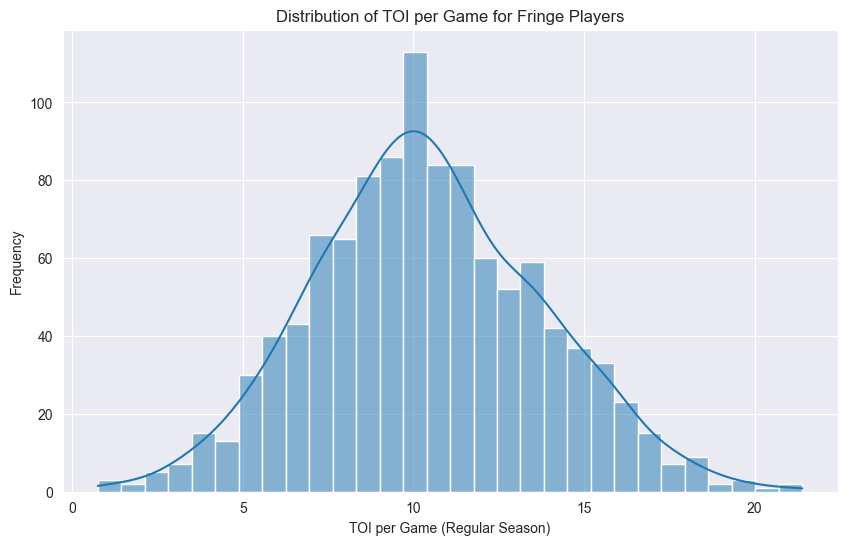

In [35]:
# Show the histogram of nhl_fringe_players' toi_per_game_regular
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(nhl_fringe_players['toi_per_game_regular'], bins=30, kde=True)
plt.title('Distribution of TOI per Game for Fringe Players')
plt.xlabel('TOI per Game (Regular Season)')
plt.ylabel('Frequency')
plt.show()

In [36]:
# Write to CSV
nhl_fringe_players.to_csv('../dataset/preprocess/nhl_fringe_players.csv', index=False, encoding='utf-8-sig')

In [37]:
# Remove fringe players from nhl_players_without_rookies
nhl_players_without_rookies_and_fringe = nhl_players_without_rookies[~nhl_players_without_rookies['player_id'].isin(fringe_players_id)]

In [38]:
nhl_players_without_rookies_and_fringe

,player_id,player_name_official,rookie_age,age_by_2025,first_season,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,...,date_of_birth,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description
0,1.0,Joe Sakic,18,56,1988-89,20,20,1378.0,15.0,84.0,...,7/7/1969,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...
1,2.0,Peter Forsberg,20,52,1994-95,13,12,708.0,2.0,82.0,...,7/20/1973,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...
2,3.0,Milan Hejduk,21,49,1998-99,14,14,1020.0,29.0,82.0,...,2/14/1976,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...
3,4.0,Alex Tanguay,19,45,1999-00,16,16,1088.0,16.0,82.0,...,11/21/1979,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...
4,5.0,Chris Drury,21,49,1998-99,12,12,892.0,24.0,82.0,...,8/20/1976,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,3897.0,Viktor Tikhonov,19,37,2008-09,2,2,111.0,11.0,61.0,...,5/12/1988,Russia,187,87,R,NaN,NaN,"('1', '28', '2008')","['1-time World Championship Gold Medal', '1-ti...",Tikhonov is a forward with fine offensive abil...
3633,3910.0,Mario Kempe,28,37,2017-18,2,2,70.0,18.0,52.0,...,9/19/1988,Sweden,183,86,L,NaN,NaN,"('5', '122', '2007')",['1-time U20 WJC Silver Medal'],Kempe is very good skater with good accelerati...
3635,3912.0,Victor Soderstrom,18,24,2020-21,4,2,53.0,3.0,30.0,...,2/26/2001,Sweden,184,89,R,NaN,Boston Bruins / Signed,"('1', '11', '2019')","['1-time U18 WJC Gold Medal', '1-time Hlinka G...",An uber competitive two-way defenceman who thi...
3636,3913.0,Dysin Mayo,24,29,2021-22,2,2,82.0,15.0,67.0,...,8/17/1996,Canada,184,86,R,NaN,NaN,"('5', '133', '2014')","['1-time U17 WHC Silver Medal', '1-time World ...",NaN


In [39]:
# Write to CSV
nhl_players_without_rookies_and_fringe.to_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata_without_rookies_and_fringe.csv', index=False, encoding='utf-8-sig')

## Divde Players into Forwards and Defensemen

In [40]:
# Load NHL Players without Rookies and Fringe Players
nhl_players_without_rookies_and_fringe = pd.read_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata_without_rookies_and_fringe.csv')

In [41]:
nhl_players_without_rookies_and_fringe.shape

(2561, 71)

In [42]:
# Divide players into forwards and defensemen
nhl_defensemen_id = nhl_players_without_rookies_and_fringe[
    nhl_players_without_rookies_and_fringe['player_pos_official'] == 'D'
]['player_id']

In [43]:
nhl_defensemen_id.shape

(870,)

In [44]:
# Get Defensemen
nhl_defensemen = nhl_players_without_rookies_and_fringe[
    nhl_players_without_rookies_and_fringe['player_id'].isin(nhl_defensemen_id)
]

In [45]:
nhl_defensemen.shape

(870, 71)

In [46]:
# Forwards are all others
nhl_forwards_id = nhl_players_without_rookies_and_fringe[
    ~nhl_players_without_rookies_and_fringe['player_id'].isin(nhl_defensemen_id)
]['player_id']

In [47]:
nhl_forwards_id.shape

(1691,)

In [48]:
# Get Forwards
nhl_forwards = nhl_players_without_rookies_and_fringe[
    nhl_players_without_rookies_and_fringe['player_id'].isin(nhl_forwards_id)
]

In [49]:
nhl_forwards.shape

(1691, 71)

## Write to CSV

In [50]:
# Write nhl_defensemen to CSV
nhl_defensemen.to_csv('../dataset/preprocess/nhl_defensemen.csv', index=False, encoding='utf-8-sig')

In [51]:
# Write nhl_forwards to CSV
nhl_forwards.to_csv('../dataset/preprocess/nhl_forwards.csv', index=False, encoding='utf-8-sig')

## Get the First 3 Seasons' Career Stats

- Get the first 3 seasons' career stats for players not in the rookies and fringe player set.

- This will be used to train the Logistic Regression model to predict rookies' tier.

In [96]:
# Load Main Players
nhl_main_players = pd.read_csv('../dataset/preprocess/nhl_players_career_stats_with_metadata_without_rookies_and_fringe.csv')
nhl_main_players.shape

(2561, 71)

In [97]:
# Get the ID of these main players
main_players_id = nhl_main_players['player_id']

# Load the NHL Players Stats
nhl_players_stats = pd.read_csv('../dataset/nhl_players_official_stats_with_id_sorted.csv')

# Copy only the main players' stats
nhl_main_players_stats = nhl_players_stats[nhl_players_stats['player_id'].isin(main_players_id)].copy()

# Copy only the NHL stats
nhl_main_players_stats = nhl_main_players_stats[nhl_main_players_stats['league'] == 'NHL'].copy()

nhl_main_players_stats.shape

(25747, 37)

In [99]:
# Get the first 3 seasons' stats for each player
nhl_main_players_3_season_stats = nhl_main_players_stats.groupby('player_id').head(3)
nhl_main_players_3_season_stats.head(3)

,player_id,player_name_official,season,league,team,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,...,ppg_playoffs,ppp_playoffs,shg_playoffs,shp_playoffs,toi_per_game_playoffs,gwg_playoffs,otg_playoffs,sog_playoffs,shooting_pct_playoffs,fo_pct_playoffs
6,1.0,Joe Sakic,1988-89,NHL,Quebec Nordiques,70.0,23.0,39.0,62.0,-36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,Joe Sakic,1989-90,NHL,Quebec Nordiques,80.0,39.0,63.0,102.0,-40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,Joe Sakic,1990-91,NHL,Quebec Nordiques,80.0,48.0,61.0,109.0,-26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Write to CSV
nhl_main_players_3_season_stats.to_csv('../dataset/preprocess/nhl_main_players_3_season_stats.csv', index=False, encoding='utf-8-sig')

4## Aggregate First 3 Seasons' Stats

In [152]:
# Aggregate first 3 seasons' career stats
# Load first 3 seasons' stats
first_3_seasons_stats = pd.read_csv('../dataset/preprocess/nhl_main_players_3_season_stats.csv')

# Step 1: Copy the first 3 seasons' stats
first_3_seasons_stats = nhl_main_players_3_season_stats.copy()

first_3_seasons_stats.head(6)

,player_id,player_name_official,season,league,team,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,...,ppg_playoffs,ppp_playoffs,shg_playoffs,shp_playoffs,toi_per_game_playoffs,gwg_playoffs,otg_playoffs,sog_playoffs,shooting_pct_playoffs,fo_pct_playoffs
6,1.0,Joe Sakic,1988-89,NHL,Quebec Nordiques,70.0,23.0,39.0,62.0,-36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,Joe Sakic,1989-90,NHL,Quebec Nordiques,80.0,39.0,63.0,102.0,-40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,Joe Sakic,1990-91,NHL,Quebec Nordiques,80.0,48.0,61.0,109.0,-26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,2.0,Peter Forsberg,1994-95,NHL,Quebec Nordiques,47.0,15.0,35.0,50.0,17.0,...,1.0,1.0,0.0,0.0,NaN,0.0,0.0,13.0,15.4,NaN
51,2.0,Peter Forsberg,1995-96,NHL,Colorado Avalanche,82.0,30.0,86.0,116.0,26.0,...,3.0,6.0,0.0,0.0,NaN,1.0,0.0,50.0,20.0,NaN
53,2.0,Peter Forsberg,1996-97,NHL,Colorado Avalanche,65.0,28.0,58.0,86.0,31.0,...,3.0,8.0,0.0,0.0,NaN,0.0,0.0,35.0,14.3,NaN


### Calculate the effective TOI per game

Since early player doesn't have `TOI` stats in their first few season, we will use their career average `TOI` per game as their first season's `TOI` per game.

In [153]:
first_3_seasons_toi_df = calculate_effective_toi(first_3_seasons_stats)
first_3_seasons_toi_df.head(5)

,player_id,total_effective_toi_regular,total_effective_toi_playoffs,toi_per_game_regular,toi_per_game_playoffs,gp_regular_effective,gp_playoffs_effective
0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,3.0,4518.100000,1088.650000,18.516803,19.440179,244.0,56.0
3,4.0,3935.166667,958.700000,17.259503,16.249153,228.0,59.0
4,5.0,3849.400000,971.666667,16.592241,16.468927,232.0,59.0


### Observe the distribution of the `career_toi_per_game_regular` and `career_toi_per_game_playoffs`

In [154]:
# Load career stats
nhl_career_stats = pd.read_csv('../dataset/nhl_players_career_stats.csv')

# Get `player_id`, `toi_per_game_regular`, `toi_per_game_playoffs` from career stats
career_toi_df = nhl_career_stats[['player_id', 'toi_per_game_regular', 'toi_per_game_playoffs']].copy()
career_toi_df.describe()

,player_id,toi_per_game_regular,toi_per_game_playoffs
count,3926.000000,3926.000000,3926.000000
mean,1963.502038,13.610424,8.120151
std,1133.486435,4.318487,8.215492
min,1.000000,0.750000,0.000000
25%,982.250000,10.566667,0.000000
50%,1963.500000,13.454979,7.641667
75%,2944.750000,16.633924,15.434366
max,3928.000000,28.228106,30.354487


### Fill `first_3_seasons_toi_df`'s `0` with their career average `TOI`

In [155]:
# Merge `first_3_seasons_toi_df` and `career_toi_df` on `player_id`
first_3_seasons_toi_df = first_3_seasons_toi_df.merge(career_toi_df, on='player_id', how='left')

# Rename columns
first_3_seasons_toi_df = first_3_seasons_toi_df.rename(columns={
    'toi_per_game_regular_x': 'toi_per_game_regular',
    'toi_per_game_playoffs_x': 'toi_per_game_playoffs',
    'toi_per_game_regular_y': 'career_toi_per_game_regular',
    'toi_per_game_playoffs_y': 'career_toi_per_game_playoffs'
})

In [156]:
first_3_seasons_toi_df.head(5)

,player_id,total_effective_toi_regular,total_effective_toi_playoffs,toi_per_game_regular,toi_per_game_playoffs,gp_regular_effective,gp_playoffs_effective,career_toi_per_game_regular,career_toi_per_game_playoffs
0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,21.776026,22.627548
1,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,20.654021,20.811610
2,3.0,4518.100000,1088.650000,18.516803,19.440179,244.0,56.0,18.587484,19.209077
3,4.0,3935.166667,958.700000,17.259503,16.249153,228.0,59.0,17.755009,16.835204
4,5.0,3849.400000,971.666667,16.592241,16.468927,232.0,59.0,17.951065,17.242963


In [157]:
# Fill `first_3_seasons_toi_df`'s `NaN` with their career average `TOI`
# Regular season
first_3_seasons_toi_df['toi_per_game_regular'] = np.where(
    first_3_seasons_toi_df['toi_per_game_regular'] == 0,
    first_3_seasons_toi_df['career_toi_per_game_regular'],
    first_3_seasons_toi_df['toi_per_game_regular']
)

# Playoffs
first_3_seasons_toi_df['toi_per_game_playoffs'] = np.where(
    first_3_seasons_toi_df['toi_per_game_playoffs'] == 0,
    first_3_seasons_toi_df['career_toi_per_game_playoffs'],
    first_3_seasons_toi_df['toi_per_game_playoffs']
)


In [158]:
first_3_seasons_toi_df.head(5)

,player_id,total_effective_toi_regular,total_effective_toi_playoffs,toi_per_game_regular,toi_per_game_playoffs,gp_regular_effective,gp_playoffs_effective,career_toi_per_game_regular,career_toi_per_game_playoffs
0,1.0,0.000000,0.000000,21.776026,22.627548,0.0,0.0,21.776026,22.627548
1,2.0,0.000000,0.000000,20.654021,20.811610,0.0,0.0,20.654021,20.811610
2,3.0,4518.100000,1088.650000,18.516803,19.440179,244.0,56.0,18.587484,19.209077
3,4.0,3935.166667,958.700000,17.259503,16.249153,228.0,59.0,17.755009,16.835204
4,5.0,3849.400000,971.666667,16.592241,16.468927,232.0,59.0,17.951065,17.242963


### Keep the columns we need

`player_id`, `toi_per_game_regular`, `toi_per_game_playoffs`

In [159]:
# Keep the columns we need
first_3_seasons_toi_df = first_3_seasons_toi_df[['player_id', 'toi_per_game_regular', 'toi_per_game_playoffs']]
first_3_seasons_toi_df.head(3)

,player_id,toi_per_game_regular,toi_per_game_playoffs
0,1.0,21.776026,22.627548
1,2.0,20.654021,20.811610
2,3.0,18.516803,19.440179


In [160]:
# Convert columns that should be numeric
numeric_cols = [
    "gp_regular", "g_regular", "a_regular", "p_regular",
    "plus_minus_regular", "pim_regular", "ppg_regular", "ppp_regular",
    "shg_regular", "shp_regular", "gwg_regular", "otg_regular", "sog_regular",
    "shooting_pct_regular", "fo_pct_regular",
    "gp_playoffs", "g_playoffs", "a_playoffs", "p_playoffs",
    "plus_minus_playoffs", "pim_playoffs", "ppg_playoffs", "ppp_playoffs",
    "shg_playoffs", "shp_playoffs", "gwg_playoffs", "otg_playoffs", "sog_playoffs",
    "shooting_pct_playoffs", "fo_pct_playoffs"
]

for col in numeric_cols:
    first_3_seasons_stats[col] = pd.to_numeric(first_3_seasons_stats[col], errors="coerce")

# Fill NaN with 0
first_3_seasons_stats = first_3_seasons_stats.fillna(0)

# Add extra stats before aggregation
agg_funcs = {
    "gp_regular": "sum",
    "g_regular": "sum",
    "a_regular": "sum",
    "p_regular": "sum",
    "plus_minus_regular": "sum",
    "pim_regular": "sum",
    "ppg_regular": "sum",
    "ppp_regular": "sum",
    "shg_regular": "sum",
    "shp_regular": "sum",
    "gwg_regular": "sum",
    "otg_regular": "sum",
    "sog_regular": "sum",
    "shooting_pct_regular": "mean",  # percentage -> average
    "fo_pct_regular": "mean",        # percentage -> average
    "gp_playoffs": "sum",
    "g_playoffs": "sum",
    "a_playoffs": "sum",
    "p_playoffs": "sum",
    "plus_minus_playoffs": "sum",
    "pim_playoffs": "sum",
    "ppg_playoffs": "sum",
    "ppp_playoffs": "sum",
    "shg_playoffs": "sum",
    "shp_playoffs": "sum",
    "gwg_playoffs": "sum",
    "otg_playoffs": "sum",
    "sog_playoffs": "sum",
    "shooting_pct_playoffs": "mean",  # %
    "fo_pct_playoffs": "mean",        # %
}

# Aggregate
first_3_seasons_stats = first_3_seasons_stats.groupby(
    ["player_id", "player_name_official"]
).agg(agg_funcs)


In [161]:
first_3_seasons_stats.head(3)

,,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,pim_regular,ppg_regular,ppp_regular,shg_regular,shp_regular,...,pim_playoffs,ppg_playoffs,ppp_playoffs,shg_playoffs,shp_playoffs,gwg_playoffs,otg_playoffs,sog_playoffs,shooting_pct_playoffs,fo_pct_playoffs
player_id,player_name_official,,,,,,,,,,,,,,,,,,,,,
1.0,Joe Sakic,230.0,110.0,163.0,273.0,-102.0,75.0,30.0,100.0,4.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2.0,Peter Forsberg,194.0,73.0,179.0,252.0,74.0,136.0,15.0,80.0,7.0,15.0,...,32.0,7.0,15.0,0.0,0.0,1.0,0.0,98.0,16.566667,0.000000
3.0,Milan Hejduk,244.0,91.0,108.0,199.0,54.0,78.0,29.0,65.0,1.0,4.0,...,16.0,8.0,17.0,0.0,0.0,5.0,2.0,139.0,13.166667,53.066667


In [162]:
# Reset index to make player_id and player_name_official regular columns
first_3_seasons_stats = first_3_seasons_stats.reset_index()

# Merge first_3_seasons_toi_df into first_3_seasons_stats
first_3_seasons_stats = first_3_seasons_stats.merge(first_3_seasons_toi_df, on='player_id', how='left')

In [163]:
first_3_seasons_stats.head(3)

,player_id,player_name_official,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,pim_regular,ppg_regular,ppp_regular,...,ppp_playoffs,shg_playoffs,shp_playoffs,gwg_playoffs,otg_playoffs,sog_playoffs,shooting_pct_playoffs,fo_pct_playoffs,toi_per_game_regular,toi_per_game_playoffs
0,1.0,Joe Sakic,230.0,110.0,163.0,273.0,-102.0,75.0,30.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,21.776026,22.627548
1,2.0,Peter Forsberg,194.0,73.0,179.0,252.0,74.0,136.0,15.0,80.0,...,15.0,0.0,0.0,1.0,0.0,98.0,16.566667,0.000000,20.654021,20.811610
2,3.0,Milan Hejduk,244.0,91.0,108.0,199.0,54.0,78.0,29.0,65.0,...,17.0,0.0,0.0,5.0,2.0,139.0,13.166667,53.066667,18.516803,19.440179


### Calculate per-game stats

In [164]:
# Calculate per-game stats
first_3_seasons_stats['g_regular_per_game'] = first_3_seasons_stats['g_regular'] / first_3_seasons_stats['gp_regular']
first_3_seasons_stats['a_regular_per_game'] = first_3_seasons_stats['a_regular'] / first_3_seasons_stats['gp_regular']
first_3_seasons_stats['p_regular_per_game'] = first_3_seasons_stats['p_regular'] / first_3_seasons_stats['gp_regular']
first_3_seasons_stats['sog_regular_per_game'] = first_3_seasons_stats['sog_regular'] / first_3_seasons_stats['gp_regular']
first_3_seasons_stats['pim_regular_per_game'] = first_3_seasons_stats['pim_regular'] / first_3_seasons_stats['gp_regular']

# Calculate per-game stats for playoffs
first_3_seasons_stats['g_playoffs_per_game'] = first_3_seasons_stats['g_playoffs'] / first_3_seasons_stats['gp_playoffs']
first_3_seasons_stats['a_playoffs_per_game'] = first_3_seasons_stats['a_playoffs'] / first_3_seasons_stats['gp_playoffs']
first_3_seasons_stats['p_playoffs_per_game'] = first_3_seasons_stats['p_playoffs'] / first_3_seasons_stats['gp_playoffs']
first_3_seasons_stats['sog_playoffs_per_game'] = first_3_seasons_stats['sog_playoffs'] / first_3_seasons_stats['gp_playoffs']
first_3_seasons_stats['pim_playoffs_per_game'] = first_3_seasons_stats['pim_playoffs'] / first_3_seasons_stats['gp_playoffs']

first_3_seasons_stats.head(3)

,player_id,player_name_official,gp_regular,g_regular,a_regular,p_regular,plus_minus_regular,pim_regular,ppg_regular,ppp_regular,...,g_regular_per_game,a_regular_per_game,p_regular_per_game,sog_regular_per_game,pim_regular_per_game,g_playoffs_per_game,a_playoffs_per_game,p_playoffs_per_game,sog_playoffs_per_game,pim_playoffs_per_game
0,1.0,Joe Sakic,230.0,110.0,163.0,273.0,-102.0,75.0,30.0,100.0,...,0.478261,0.708696,1.186957,2.726087,0.326087,NaN,NaN,NaN,NaN,NaN
1,2.0,Peter Forsberg,194.0,73.0,179.0,252.0,74.0,136.0,15.0,80.0,...,0.376289,0.922680,1.298969,2.530928,0.701031,0.404762,0.642857,1.047619,2.333333,0.761905
2,3.0,Milan Hejduk,244.0,91.0,108.0,199.0,54.0,78.0,29.0,65.0,...,0.372951,0.442623,0.815574,2.536885,0.319672,0.321429,0.464286,0.785714,2.482143,0.285714


### Reorder the column

In [165]:
regular_cols = [
    "gp_regular", "g_regular", "a_regular", "p_regular", "plus_minus_regular", "toi_per_game_regular", "pim_regular",
    "ppg_regular", "ppp_regular", "shg_regular", "shp_regular", "gwg_regular", "otg_regular", "sog_regular",
    "shooting_pct_regular", "fo_pct_regular"
]

playoff_cols = [
    "gp_playoffs", "g_playoffs", "a_playoffs", "p_playoffs", "plus_minus_playoffs", "toi_per_game_playoffs", "pim_playoffs",
    "ppg_playoffs", "ppp_playoffs", "shg_playoffs", "shp_playoffs", "gwg_playoffs", "otg_playoffs", "sog_playoffs",
    "shooting_pct_playoffs", "fo_pct_playoffs"
]

per_game_cols = [
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game", "sog_regular_per_game", "pim_regular_per_game",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game", "sog_playoffs_per_game", "pim_playoffs_per_game"
]

# Now build the full order
ordered_cols = ["player_id", "player_name_official"] + regular_cols + playoff_cols + per_game_cols

# In case there are any extras we missed, append them at the end
extras = [c for c in first_3_seasons_stats.columns if c not in ordered_cols]
ordered_cols += extras

# Reorder DataFrame
first_3_seasons_stats = first_3_seasons_stats[ordered_cols]

## Write to CSV

In [166]:
first_3_seasons_stats.to_csv('../dataset/preprocess/nhl_main_players_3_season_stats_aggregated.csv', index=False, encoding='utf-8-sig')
